# Global sea-level budget
Compute the sea-level budget as a function of time based on [ocean mass](http://dx.doi.org/10.1002/2014JB011547) and [steric](http://www.nature.com/nclimate/journal/v4/n11/full/nclimate2387.html) effects.   
The ice contribution of [Antarctica](10.1002/2014JB011547) and [Greenland](10.1002/2014JB011547) are also shown. 

In [1]:
import pathlib
import datetime

# data
import netCDF4
import pandas as pd
import numpy as np

# plots
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean.cm

# stats
import statsmodels.stats.outliers_influence
import statsmodels.sandbox.regression.predstd
import statsmodels.graphics.regressionplots
import statsmodels.regression
import statsmodels.tsa.seasonal
import scipy.interpolate

# interaction
import tqdm
from IPython.display import YouTubeVideo, display

%matplotlib inline


greenish = list(matplotlib.rcParams['axes.prop_cycle'])[8]['color']

In [2]:
description = [
    'altimeter type 0=dual-frequency  999=single frequency (ie Poseidon-1)',
    'merged file cycle #',
    'year+fraction of year (mid-cycle)',
    'number of observations',
    'number of weighted observations',
    'GMSL (Global Isostatic Adjustment (GIA) not applied) variation (mm) with respect to 20-year TOPEX/Jason collinear mean reference',
    'standard deviation of GMSL (GIA not applied) variation estimate (mm)',
    'smoothed (60-day Gaussian type filter) GMSL (GIA not applied) variation (mm)  with respect to 20-year mean',
    'GMSL (Global Isostatic Adjustment (GIA) applied) variation (mm) )  with respect to 20-year mean',
    'standard deviation of GMSL (GIA applied) variation estimate (mm)',
    'smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm) )  with respect to 20-year mean',
    'smoothed (60-day Gaussian type filter) GMSL (GIA applied) variation (mm); annual and semi-annual signal removed )  with respect to 20-year mean'
],
columns = [
    'altimeter type',
    'file cycle #',
    'year',
    'n observations',
    'n weighted observations',
    'GMSL',
    'GMSL_sd',
    'GMSL_smooth',
    'GMSL_gia',
    'GMSL_gia_sd',
    'GMSL_gia_smooth',
    'GMSL_gia_smooth_deseasoned'
]
    

gmsl_df = pd.read_csv('/Users/baart_f/src/sealevel/data/nasa/gmsl.txt', comment='H', sep='\s+', names=columns)
ocean_mass_df = pd.read_json('/Users/baart_f/src/sealevel/data/nasa/ocean_mass.json')
steric_df = pd.read_csv('/Users/baart_f/src/sealevel/data/nasa/OCN_steric_height_changes_Llovel2014.csv', skiprows=5, names=['year', 'slr'])
# cm to mm
steric_df['slr'] *= 10
greenland_df = pd.read_json('/Users/baart_f/src/sealevel/data/nasa/greenland_mass.json')
antarctica_df = pd.read_json('/Users/baart_f/src/sealevel/data/nasa/antarctica_mass.json')

# m to mm
greenland_df['slr'] *= 1000
antarctica_df['slr'] *= 1000

# combine ocean and steric
ocean_slr = scipy.interpolate.interp1d(ocean_mass_df.year, ocean_mass_df.slr_deseasoned)(steric_df.year)
ocean_and_steric = pd.DataFrame(data=dict(year=steric_df.year, steric_slr=steric_df.slr, ocean_slr=ocean_slr))

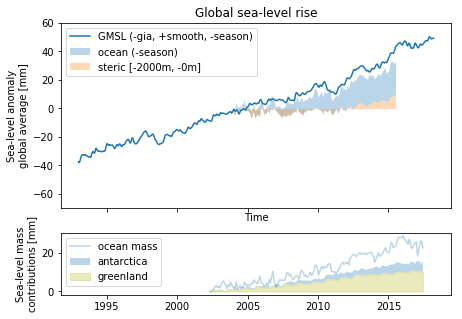

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(7, 5), sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[3, 1]))
axes[0].set_title('Global sea-level rise')
# get the start of te ocean dataset
idxmin = np.abs(gmsl_df.year - ocean_and_steric.year.iloc[0]).idxmin()
GMSL_se = gmsl_df.GMSL_sd/np.sqrt(gmsl_df['n observations'])

# line up at start of series
correction = gmsl_df.GMSL_gia_smooth_deseasoned.iloc[idxmin]

axes[0].plot(gmsl_df.year, gmsl_df.GMSL_gia_smooth_deseasoned, label='GMSL (-gia, +smooth, -season)')

axes[0].fill_between(ocean_and_steric['year'], correction + ocean_and_steric['steric_slr'], correction  + ocean_and_steric['steric_slr'] + ocean_and_steric['ocean_slr'], alpha=0.3, label='ocean (-season)')
axes[0].fill_between(ocean_and_steric['year'], correction + ocean_and_steric['steric_slr'], correction, alpha=0.3, label='steric [-2000m, -0m]')

axes[1].fill_between(greenland_df['year'], y1=greenland_df['slr'], y2=greenland_df['slr'] + antarctica_df['slr'], alpha=0.3, label='antarctica')
axes[1].fill_between(antarctica_df['year'], greenland_df['slr'], alpha=0.3, label='greenland', color=greenish)
axes[1].plot(ocean_mass_df['year'], ocean_mass_df['slr_deseasoned'], alpha=0.3, label='ocean mass')

axes[0].set_xlabel('Time')
axes[0].set_ylabel('Sea-level anomaly\nglobal average [mm]')



axes[0].set_ylim(-70, 60)
axes[0].legend(loc='best')
axes[1].set_ylabel('Sea-level mass\ncontributions [mm]')
axes[1].legend(loc='upper left')

In [4]:
fig.savefig('global-budget.pdf')